In [34]:
import baltic as bt
from matplotlib import pyplot as plt
%matplotlib inline
import json
import seaborn as sns
from collections import defaultdict
import pandas as pd
import numpy as np

In [2]:
json_key = {'name': 'strain', 'height': 'xvalue'}
titer_tree = bt.loadJSON('/Users/Sidney/nextstrain/augur/builds/dengue/auspice/dengue_all_tree.json', json_key)



Tree height: 0.357550
Tree length: 6.132190
annotations present

Numbers of objects in tree: 2998 (1428 nodes and 1570 leaves)



In [3]:
dTiter_vals = [n.traits['dTiter'] for n in titer_tree.nodes]
print sorted(dTiter_vals)[int(len(dTiter_vals)/2)]
print min(dTiter_vals)
print max(dTiter_vals)

0
0
1.15979720694


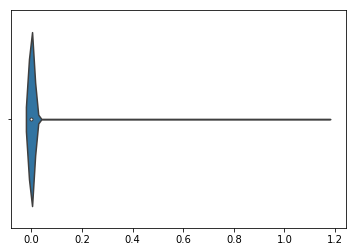

In [4]:
sns.violinplot(dTiter_vals)

In [120]:
def get_antigenic_mutations(tree, cutoff):
    dTiter_records = []
    dTiter_branches = [n for n in titer_tree.nodes if n.traits['dTiter'] >= cutoff]

    def parse_mutations(gene, mut, branch_record):
        mut_record = branch_record.copy()
        mut_record['gene'] = gene
        mut_record['site'] = int(mut[1:-1])
        mut_record['allele0'] = mut[0]
        mut_record['allele1'] = mut[-1]
        return mut_record
    
    for branch in dTiter_branches:
        branch_record = {
            'dTiter': float(branch.traits['dTiter']),
            'branch_id': branch.traits['clade'],
            'leaves': branch.leaves,
        }
        
        descendent_serotypes = [l.split('/')[0] for l in branch_record['leaves'] if not l.startswith('DENV/')] ## Why are there so many DENV seqs?
        
        if len(set(descendent_serotypes)) == 1:
            branch_record['serotype'] = descendent_serotypes[0]
        else:
            branch_record['serotype'] = np.nan
        
        E_muts = branch.traits['aa_muts']['E']
        M_muts = branch.traits['aa_muts']['M']
        
        for E_mut in E_muts:
            dTiter_records.append(parse_mutations('E', E_mut, branch_record))
        for M_mut in M_muts:
            dTiter_records.append(parse_mutations('M', M_mut, branch_record))
            
    return pd.DataFrame(dTiter_records)

In [121]:
antigenic_mutations = get_antigenic_mutations(titer_tree, 0.15)
E_antigenic_mutations = antigenic_mutations.loc[antigenic_mutations['gene'] == 'E']

intraserotype_antigenic_mutations = antigenic_mutations.loc[~antigenic_mutations['serotype'].isnull()]
E_intraserotype_antigenic_mutations = intraserotype_antigenic_mutations.loc[intraserotype_antigenic_mutations['gene'] == 'E']

In [122]:
#### Why are the dTiter values behaving suspiciously like cTiter....??

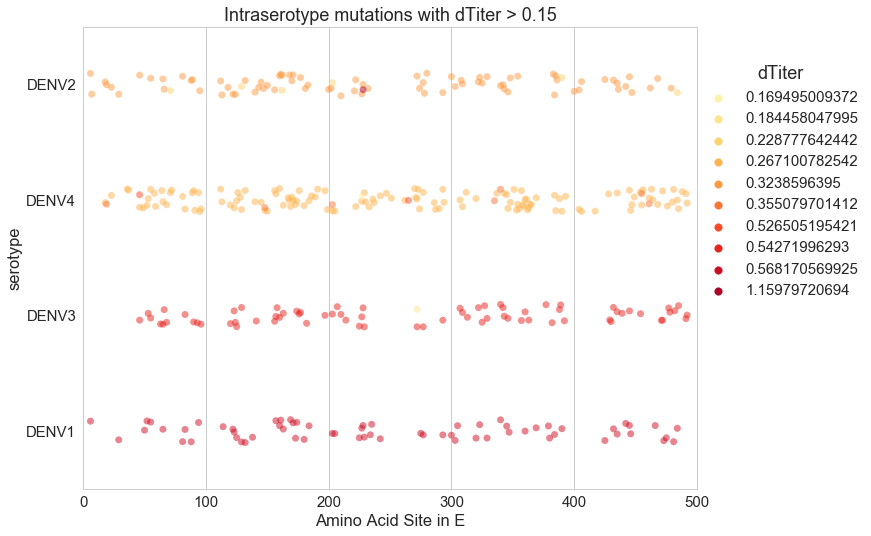

In [147]:
sns.set(style='whitegrid', font_scale=1.5)
fig, ax = plt.subplots(figsize=(11,8.5))
sns.stripplot(x='site', y='serotype', hue='dTiter', 
              data=E_intraserotype_antigenic_mutations, 
              orient='h', palette="YlOrRd", ax=ax, s=7, 
              alpha=0.5, jitter=True)

ax.legend(loc=(1,.4), title='dTiter')
ax.set_xlim(0, 500)

ax.set_title('Intraserotype mutations with dTiter > 0.15')
ax.set_xlabel('Amino Acid Site in E')